In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, cross_validate

pd.options.display.max_colwidth = -1
pd.options.display.max_columns = 300
pd.options.display.max_rows = 100

In [34]:
def WOE(data, columns, target):
    if type(columns) != list:
        columns = [columns]
    WOE_cols = {}
    for col in columns:
        data[col] = data[col].fillna('NoData')
        WOE_data = data[[col,target]].groupby(col)[target].agg(['count','sum']).reset_index()
        WOE_data.columns = [col,'count','sum']
        WOE_data['sum %'] = (WOE_data['sum'] / WOE_data['sum'].sum()*100).round(2)
        WOE_data['count %'] = (WOE_data['count'] / WOE_data['count'].sum()*100).round(2)
        WOE_data[col + '_WOE'] = np.log(WOE_data['sum %'] / WOE_data['count %']).round(2)
        WOE_cols[col] = WOE_data[[col, col + '_WOE']]
        
    return WOE_cols

In [35]:
def cleaning_nan(data, percentage):
    unused_cols = []
    for col in data.columns.tolist():
        if data[col].isna().mean() >= percentage:
            unused_cols.append(col)
            print(col)
            
    data.drop(unused_cols, axis = 1, inplace = True)
    return data, unused_cols

In [60]:
def filling_nan(data):
    
    def score(quality):
        if quality == 'Ex':
            return 5
        elif quality == 'Gd':
            return 4
        elif quality == 'TA':
            return 3
        elif quality == 'Fa':
            return 2
        elif quality == 'Po':
            return 1
        else:
            return 0
        
    data.GarageQual = data.GarageQual.apply(score)
    data.GarageCond = data.GarageCond.apply(score)
    data.GarageQual = data.GarageQual + data.GarageCond
    
    data['GarageAttchd'] = data.GarageType.apply(lambda x: x != np.nan and x != 'Detchd')
    data['PorchArea'] = data['3SsnPorch'] + data.OpenPorchSF + data.EnclosedPorch + data.ScreenPorch
    data['Bathrooms'] = data.BsmtHalfBath + data.BsmtFullBath + data.FullBath + data.HalfBath
    
    data.OverallQual = data.OverallCond + data.OverallQual
    data.FireplaceQu = data.FireplaceQu.apply(score)
    data.Fireplaces *= data.FireplaceQu
    data.HeatingQC = data.HeatingQC.apply(score)
    data.KitchenQual = data.KitchenQual.apply(score)
    
    data.BsmtQual = data.BsmtQual.apply(score)
    data.BsmtCond = data.BsmtCond.apply(score)
    data.BsmtQual = data.BsmtQual + data.BsmtCond
    
    data.ExterQual = data.ExterQual.apply(score)
    data.ExterCond = data.ExterCond.apply(score)
    data.ExterQual = data.ExterQual + data.ExterCond
    data.drop(columns = ['LotFrontage',
                         'GarageType',
                         'GarageFinish', 
                         'GarageCars', 
                         'GarageCond',
                         
                         '3SsnPorch',
                         'OpenPorchSF',
                         'EnclosedPorch',
                         'ScreenPorch',
                         
                         'BsmtHalfBath',
                         'BsmtFullBath',
                         'HalfBath',
                         'FullBath',
                         
                         'BsmtCond', 
                         'BsmtExposure', 
                         'BsmtFinType1', 
                         'BsmtFinSF1',
                         'BsmtFinType2', 
                         'BsmtFinSF2',
                         '1stFlrSF',
                         '2ndFlrSF',
                         'Electrical', 
                         'ExterCond',
                         'OverallCond',
                         'YearBuilt',
                         'GarageYrBlt',
                         'FireplaceQu',
                         'PoolArea',
                         'MiscVal',
                         'Exterior2nd',
                         'SaleCondition',
                         'TotRmsAbvGrd',
                         'Id'], inplace = True)
    return data

In [37]:
def categorical_features(data):
    categorical_features = []
    for i in data:
        if data[i].dtype == object:
            categorical_features.append(i)
    return categorical_features

In [38]:
def show_nan(data):
    nan_count = {}
    for col in data.columns:
        nan_count[col] = data[col].isna().sum()
    nan_count = [i for i in nan_count.items() if i[1] != 0]
    nan_count.sort(key = lambda x: x[1], reverse = True)
    return nan_count

In [39]:
def apply(df, func):
    for i in df:
        df[i] = df[i].apply(func)
    return df

In [40]:
def plot_corr(df):
    plt.figure(figsize=(40,40))
    sns.heatmap(df.corr(),annot=True)

In [41]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [42]:
train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,Gas

In [43]:
test

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,Comp

In [44]:
train[~train.PoolQC.isna()].MiscFeature

197     NaN 
810     NaN 
1170    NaN 
1182    NaN 
1298    NaN 
1386    TenC
1423    NaN 
Name: MiscFeature, dtype: object

In [45]:
train_data, unused_cols = cleaning_nan(train.copy(), 0.5)
test_data = test.drop(unused_cols, axis = 1)

Alley
PoolQC
Fence
MiscFeature


In [46]:
train_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,NaN,Attchd,1950.0,Unf,1,240,TA,TA,Y,366,0,112,0,0,0,0,4,2010,WD,Normal,142125


In [47]:
test_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,GasA,TA,Y,SBrkr,970,0,0,970,0.0,1.0,1,0,3,1,TA,6,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,80,32,0,0,0,0,7

In [61]:
train_data_1 = filling_nan(train_data.copy())
test_data_1 = filling_nan(test_data.copy())

In [49]:
train_data_1

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageArea,GarageQual,PavedDrive,WoodDeckSF,MoSold,YrSold,SaleType,SalePrice,GarageAttchd,PorchArea,Bathrooms
0,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,12,2003,Gable,CompShg,VinylSd,BrkFace,196.0,7,PConc,7,150,856,GasA,5,Y,0,1710,3,1,4,8,Typ,0,548,6,Y,0,2,2008,WD,208500,True,61,4
1,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,14,1976,Gable,CompShg,MetalSd,None,0.0,6,CBlock,7,284,1262,GasA,5,Y,0,1262,3,1,3,6,Typ,3,460,6,Y,298,5,2007,WD,181500,True,0,3
2,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,12,2002,Gable,CompShg,VinylSd,BrkFace,162.0,7,PConc,7,434,920,GasA,5,Y,0,1786,3,1,4,6,Typ,3,608,6,Y,0,9,2008,WD,223500,True,42,4
3,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,12,1970,Gable,CompShg,Wd Sdng,None,0.0,6,BrkTil,7,540,756,GasA,4,Y,0,1717,3,1,4,7,Typ,4,642,6,Y,0,2,2006,WD,140000,False,307,2
4,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,13,2000,Gable,CompShg,VinylSd,BrkFace,350.0,7,PConc,7,490,1145,GasA,5,Y,0,2198,4,1,4,9,Typ,3,836,6,Y,192,12,2008,WD,250000,True,84,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,11,2000,Gable,CompShg,VinylSd,None,0.0,6,PConc,7,953,953,GasA,5,Y,0,1647,3,1,3,7,Typ,3,460,6,Y,0,8,2007,WD,175000,True,40,3
1456,20,RL,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,12,1988,Gable,CompShg,Plywood,Stone,119.0,6,CBlock,7,589,1542,GasA,3,Y,0,2073,3,1,3,7,Min1,6,500,6,Y,349,2,2010,WD,210000,True,0,3
1457,70,RL,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,16,2006,Gable,CompShg,CemntBd,None,0.0,9,Stone,7,877,1152,GasA,5,Y,0,2340,4,1,4,9,Typ,8,252,6,Y,0,5,2010,WD,266500,True,60,2
1458,20,RL,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,11,1996,Hip,CompShg,MetalSd,None,0.0,6,CBlock,6,0,1078,GasA,4,Y,0,1078,2,1,4,5,Typ,0,240,6,Y,366,4,2010,WD,142125,True,112,2


In [50]:
test_data_1

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageArea,GarageQual,PavedDrive,WoodDeckSF,MoSold,YrSold,SaleType,GarageAttchd,PorchArea,Bathrooms
0,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,11,1961,Gable,CompShg,VinylSd,None,0.0,6,CBlock,6,270.0,882.0,GasA,3,Y,0,896,2,1,3,5,Typ,0,730.0,6,Y,140,6,2010,WD,True,120,1.0
1,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,12,1958,Hip,CompShg,Wd Sdng,BrkFace,108.0,6,CBlock,6,406.0,1329.0,GasA,3,Y,0,1329,3,1,4,6,Typ,0,312.0,6,Y,393,6,2010,WD,True,36,2.0
2,60,RL,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,10,1998,Gable,CompShg,VinylSd,None,0.0,6,PConc,7,137.0,928.0,GasA,4,Y,0,1629,3,1,3,6,Typ,3,482.0,6,Y,212,3,2010,WD,True,34,3.0
3,60,RL,9978,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,12,1998,Gable,CompShg,VinylSd,BrkFace,20.0,6,PConc,6,324.0,926.0,GasA,5,Y,0,1604,3,1,4,7,Typ,4,470.0,6,Y,360,6,2010,WD,True,36,3.0
4,120,RL,5005,Pave,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,13,1992,Gable,CompShg,HdBoard,None,0.0,7,PConc,7,1017.0,1280.0,GasA,5,Y,0,1280,2,1,4,5,Typ,0,506.0,6,Y,0,1,2010,WD,True,226,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,1936,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,11,1970,Gable,CompShg,CemntBd,None,0.0,6,CBlock,6,546.0,546.0,GasA,4,Y,0,1092,3,1,3,5,Typ,0,0.0,0,Y,0,6,2006,WD,True,0,2.0
1455,160,RM,1894,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,9,1970,Gable,CompShg,CemntBd,None,0.0,6,CBlock,6,294.0,546.0,GasA,3,Y,0,1092,3,1,3,6,Typ,0,286.0,6,Y,0,4,2006,WD,True,24,2.0
1456,20,RL,20000,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,12,1996,Gable,CompShg,VinylSd,None,0.0,6,CBlock,6,0.0,1224.0,GasA,5,Y,0,1224,4,1,3,7,Typ,3,576.0,6,Y,474,9,2006,WD,False,0,2.0
1457,85,RL,10441,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,10,1992,Gable,CompShg,HdBoard,None,0.0,6,PConc,7,575.0,912.0,GasA,3,Y,0,970,3,1,3,6,Typ,0,0.0,0,Y,80,7,2006,WD,True,32,2.0


In [62]:
categorical = categorical_features(train_data_1) + ['MSSubClass']
WOE_values = WOE(train_data_1, categorical, 'SalePrice')
train_data_2 = train_data_1.copy()
test_data_2 = test_data_1.copy()

for col in categorical:
    train_data_2[col] = train_data_2[col].fillna('NoData')
    test_data_2[col] = test_data_2[col].fillna('NoData')
    
    train_data_2 = train_data_2.merge(WOE_values[col], on = col, how = 'left')
    test_data_2 = test_data_2.merge(WOE_values[col], on = col, how = 'left')
    
    train_data_2.drop(col, inplace = True, axis = 1)
    test_data_2.drop(col, inplace = True, axis = 1)

train_data_2.fillna(0, inplace = True)
test_data_2.fillna(0, inplace = True)

In [53]:
train_data_2

,LotArea,OverallQual,YearRemodAdd,MasVnrArea,ExterQual,BsmtQual,BsmtUnfSF,TotalBsmtSF,HeatingQC,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,GarageArea,GarageQual,WoodDeckSF,MoSold,YrSold,SalePrice,GarageAttchd,PorchArea,Bathrooms,MSZoning_WOE,Street_WOE,LotShape_WOE,LandContour_WOE,Utilities_WOE,LotConfig_WOE,LandSlope_WOE,Neighborhood_WOE,Condition1_WOE,Condition2_WOE,BldgType_WOE,HouseStyle_WOE,RoofStyle_WOE,RoofMatl_WOE,Exterior1st_WOE,MasVnrType_WOE,Foundation_WOE,Heating_WOE,CentralAir_WOE,Functional_WOE,PavedDrive_WOE,SaleType_WOE,MSSubClass_WOE
0,8450,12,2003,196.0,7,7,150,856,5,0,1710,3,1,4,8,0,548,6,0,2,2008,208500,True,61,4,0.05,0.0,-0.09,-0.0,0.0,-0.02,-0.01,0.09,0.02,0.0,0.03,0.15,-0.05,-0.01,0.17,0.12,0.22,0.01,0.03,0.01,0.03,-0.04,0.28
1,9600,14,1976,0.0,6,7,284,1262,5,0,1262,3,1,3,6,3,460,6,298,5,2007,181500,True,0,3,0.05,0.0,-0.09,-0.0,0.0,-0.02,-0.01,0.28,-0.24,0.0,0.03,-0.03,-0.05,-0.01,-0.19,-0.15,-0.19,0.01,0.03,0.01,0.03,-0.04,0.02
2,11250,12,2002,162.0,7,7,434,920,5,0,1786,3,1,4,6,3,608,6,0,9,2008,223500,True,42,4,0.05,0.0,0.13,-0.0,0.0,-0.02,-0.01,0.09,0.02,0.0,0.03,0.15,-0.05,-0.01,0.17,0.12,0.22,0.01,0.03,0.01,0.03,-0.04,0.28
3,9550,12,1970,0.0,6,7,540,756,4,0,1717,3,1,4,7,4,642,6,0,2,2006,140000,False,307,2,0.05,0.0,0.13,-0.0,0.0,0.00,-0.01,0.15,0.02,0.0,0.03,0.15,-0.05,-0.01,-0.19,-0.15,-0.31,0.01,0.03,0.01,0.03,-0.04,-0.08
4,14260,13,2000,350.0,7,7,490,1145,5,0,2198,4,1,4,9,3,836,6,192,12,2008,250000,True,84,4,0.05,0.0,0.13,-0.0,0.0,-0.02,-0.01,0.62,0.02,0.0,0.03,0.15,-0.05,-0.01,0.17,0.12,0.22,0.01,0.03,0.01,0.03,-0.04,0.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,7917,11,2000,0.0,6,7,953,953,5,0,1647,3,1,3,7,3,460,6,0,8,2007,175000,True,40,3,0.05,0.0,-0.09,-0.0,0.0,-0.02,-0.01,0.06,0.02,0.0,0.03,0.15,-0.05,-0.01,0.17,-0.15,0.22,0.01,0.03,0.01,0.03,-0.04,0.28
1456,13175,12,1988,119.0,6,7,589,1542,3,0,2073,3,1,3,7,6,500,6,349,2,2010,210000,True,0,3,0.05,0.0,-0.09,-0.0,0.0,-0.02,-0.01,0.04,0.02,0.0,0.03,-0.03,-0.05,-0.01,-0.03,0.38,-0.19,0.01,0.03,-0.21,0.03,-0.04,0.02
1457,9042,16,2006,0.0,9,7,877,1152,5,0,2340,4,1,4,9,8,252,6,0,5,2010,266500,True,60,2,0.05,0.0,-0.09,-0.0,0.0,-0.02,-0.01,0.15,0.02,0.0,0.03,0.15,-0.05,-0.01,0.25,-0.15,-0.08,0.01,0.03,0.01,0.03,-0.04,-0.08
1458,9717,11,1996,0.0,6,6,0,1078,4,0,1078,2,1,4,5,0,240,6,366,4,2010,142125,True,112,2,0.05,0.0,-0.09,-0.0,0.0,-0.02,-0.01,-0.22,0.02,0.0,0.03,-0.03,0.19,-0.01,-0.19,-0.15,-0.19,0.01,0.03,0.01,0.03,-0.04,0.02


In [54]:
test_data_2

,LotArea,OverallQual,YearRemodAdd,MasVnrArea,ExterQual,BsmtQual,BsmtUnfSF,TotalBsmtSF,HeatingQC,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,GarageArea,GarageQual,WoodDeckSF,MoSold,YrSold,GarageAttchd,PorchArea,Bathrooms,MSZoning_WOE,Street_WOE,LotShape_WOE,LandContour_WOE,Utilities_WOE,LotConfig_WOE,LandSlope_WOE,Neighborhood_WOE,Condition1_WOE,Condition2_WOE,BldgType_WOE,HouseStyle_WOE,RoofStyle_WOE,RoofMatl_WOE,Exterior1st_WOE,MasVnrType_WOE,Foundation_WOE,Heating_WOE,CentralAir_WOE,Functional_WOE,PavedDrive_WOE,SaleType_WOE,MSSubClass_WOE
0,11622,11,1961,0.0,6,6,270.0,882.0,3,0,896,2,1,3,5,0,730.0,6,140,6,2010,True,120,1.0,-0.32,0.0,-0.09,-0.00,0.0,-0.02,-0.01,-0.22,-0.24,0.0,0.03,-0.03,-0.05,-0.01,0.17,-0.15,-0.19,0.01,0.03,0.01,0.03,-0.04,0.02
1,14267,12,1958,108.0,6,6,406.0,1329.0,3,0,1329,3,1,4,6,0,312.0,6,393,6,2010,True,36,2.0,0.05,0.0,0.13,-0.00,0.0,0.00,-0.01,-0.22,0.02,0.0,0.03,-0.03,0.19,-0.01,-0.19,0.12,-0.19,0.01,0.03,0.01,0.03,-0.04,0.02
2,13830,10,1998,0.0,6,7,137.0,928.0,4,0,1629,3,1,3,6,3,482.0,6,212,3,2010,True,34,3.0,0.05,0.0,0.13,-0.00,0.0,-0.02,-0.01,0.06,0.02,0.0,0.03,0.15,-0.05,-0.01,0.17,-0.15,0.22,0.01,0.03,0.01,0.03,-0.04,0.28
3,9978,12,1998,20.0,6,6,324.0,926.0,5,0,1604,3,1,4,7,4,470.0,6,360,6,2010,True,36,3.0,0.05,0.0,0.13,-0.00,0.0,-0.02,-0.01,0.06,0.02,0.0,0.03,0.15,-0.05,-0.01,0.17,0.12,0.22,0.01,0.03,0.01,0.03,-0.04,0.28
4,5005,13,1992,0.0,7,7,1017.0,1280.0,5,0,1280,2,1,4,5,0,506.0,6,0,1,2010,True,226,2.0,0.05,0.0,0.13,0.25,0.0,-0.02,-0.01,0.54,0.02,0.0,0.01,-0.03,-0.05,-0.01,-0.10,-0.15,0.22,0.01,0.03,0.01,0.03,-0.04,0.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,1936,11,1970,0.0,6,6,546.0,546.0,4,0,1092,3,1,3,5,0,0.0,0,0,6,2006,True,0,2.0,-0.36,0.0,-0.09,-0.00,0.0,-0.02,-0.01,-0.61,0.02,0.0,-0.29,0.15,-0.05,-0.01,0.25,-0.15,-0.19,0.01,0.03,0.01,0.03,-0.04,-0.27
1455,1894,9,1970,0.0,6,6,294.0,546.0,3,0,1092,3,1,3,6,0,286.0,6,0,4,2006,True,24,2.0,-0.36,0.0,-0.09,-0.00,0.0,-0.02,-0.01,-0.61,0.02,0.0,0.01,0.15,-0.05,-0.01,0.25,-0.15,-0.19,0.01,0.03,0.01,0.03,-0.04,-0.27
1456,20000,12,1996,0.0,6,6,0.0,1224.0,5,0,1224,4,1,3,7,3,576.0,6,474,9,2006,False,0,2.0,0.05,0.0,-0.09,-0.00,0.0,-0.02,-0.01,-0.15,0.02,0.0,0.03,-0.03,-0.05,-0.01,0.17,-0.15,-0.19,0.01,0.03,0.01,0.03,-0.04,0.02
1457,10441,10,1992,0.0,6,7,575.0,912.0,3,0,970,3,1,3,6,0,0.0,0,80,7,2006,True,32,2.0,0.05,0.0,-0.09,-0.00,0.0,-0.02,-0.01,-0.15,0.02,0.0,0.03,-0.29,-0.05,-0.01,-0.10,-0.15,0.22,0.01,0.03,0.01,0.03,-0.04,-0.20


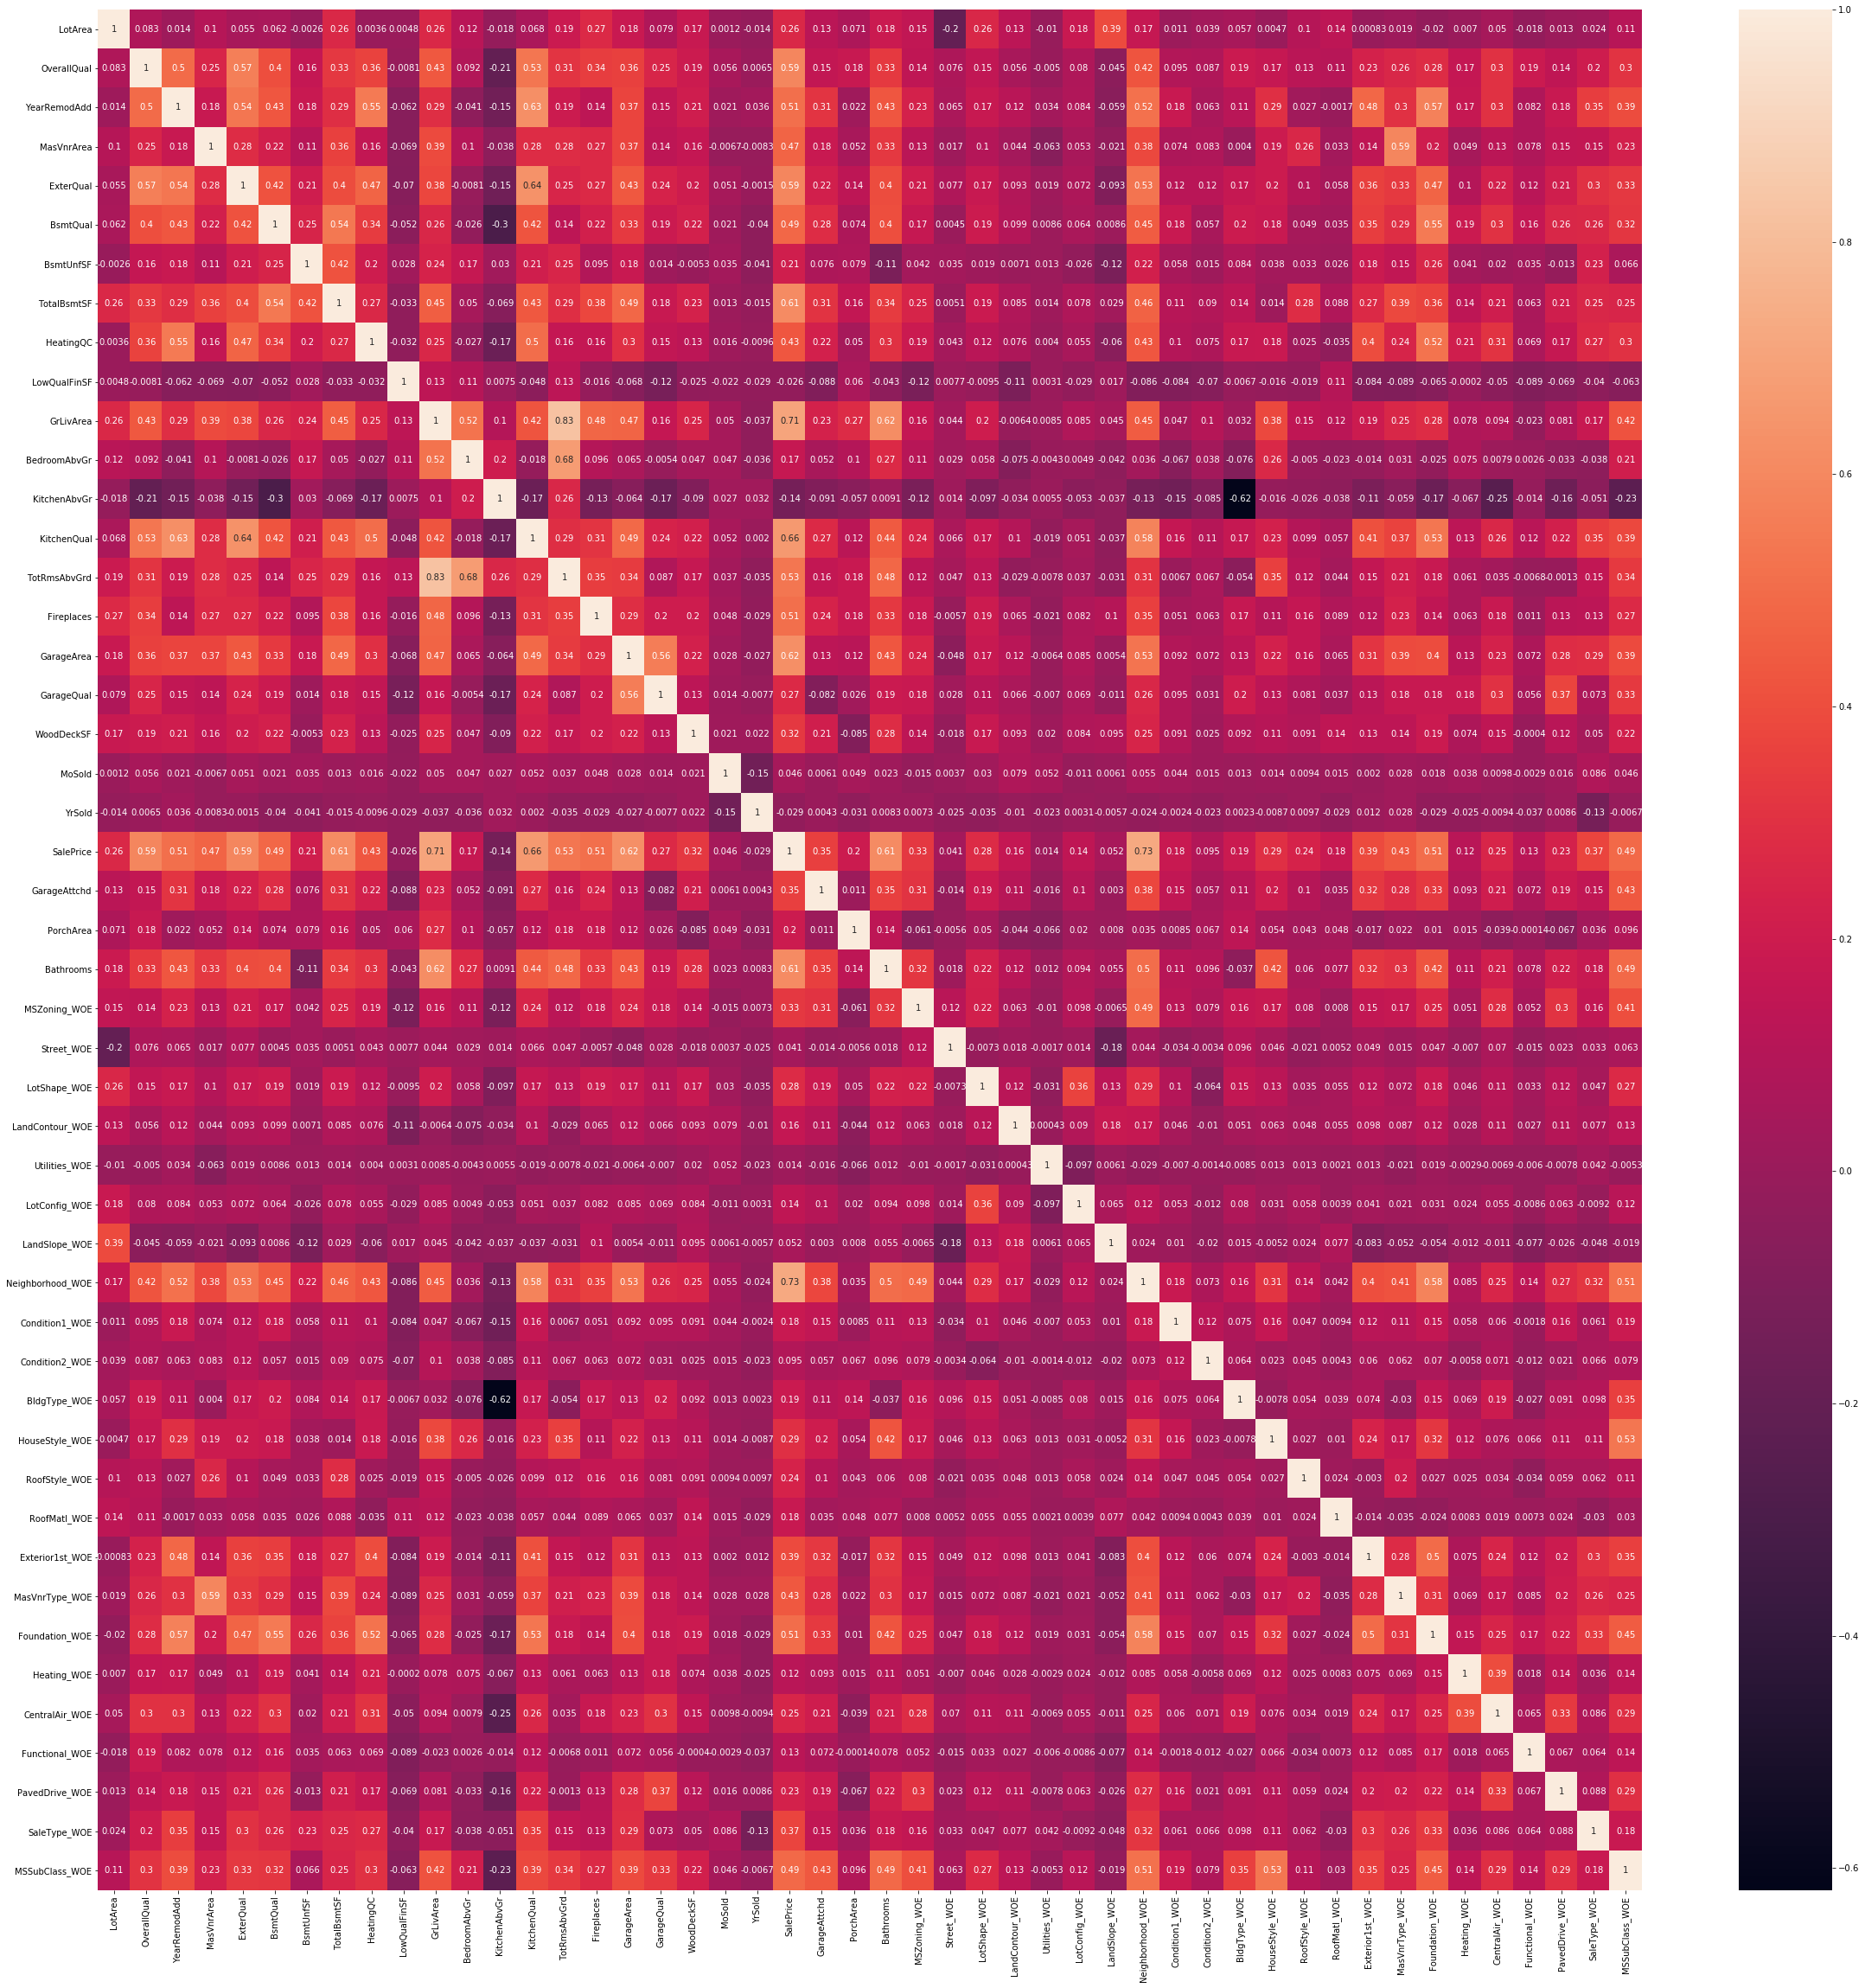

In [55]:
plot_corr(train_data_2)

In [63]:
scaler = StandardScaler()
X_test = test_data_2
X_train = scaler.fit_transform(train_data_2.drop('SalePrice', axis = 1).values)
Y_train = train_data_2['SalePrice']

In [70]:
rfr = RandomForestRegressor(200, max_features = 40, n_jobs = -1, random_state = 12, max_depth = 12)
rfr.fit(X_train, Y_train)

cross_validate(rfr, X_train, Y_train, cv = 4, n_jobs = -1, return_train_score = True)

{'fit_time': array([2.66362381, 2.62042165, 2.93988276, 2.87865472]),
 'score_time': array([0.32872367, 0.37990785, 0.10881543, 0.10824752]),
 'test_score': array([0.89522692, 0.87733918, 0.8930707 , 0.86235577]),
 'train_score': array([0.98175706, 0.98162384, 0.98243963, 0.98250577])}

In [71]:
#X = StandartScaler().fit_tansfrotm(X)
lr = LinearRegression(n_jobs = -1)
lr.fit(X_train, Y_train)

cross_validate(lr, X_train, Y_train, cv = 4, n_jobs = -1, return_train_score = True)

{'fit_time': array([0.00698161, 0.00778055, 0.00894284, 0.00698066]),
 'score_time': array([0.00199437, 0.00219178, 0.0019958 , 0.00199509]),
 'test_score': array([0.88450334, 0.84098097, 0.8300297 , 0.72275652]),
 'train_score': array([0.83152605, 0.84517221, 0.84672888, 0.87544444])}

In [72]:
mlp_reg = MLPRegressor((30), solver = 'lbfgs', alpha = 10000000, random_state = 12, max_iter = 900)
mlp_reg.fit(X_train, Y_train)

cross_validate(mlp_reg, X_train, Y_train, cv = 4, n_jobs = -1, return_train_score = True)

{'fit_time': array([0.96845388, 0.66682386, 0.98348331, 1.61378837]),
 'score_time': array([0.00299215, 0.00295329, 0.00201297, 0.00398946]),
 'test_score': array([0.90632349, 0.84286043, 0.86026099, 0.76345887]),
 'train_score': array([0.84839813, 0.85778691, 0.85920388, 0.88917755])}

In [74]:
model = lr
prediction = model.predict(scaler.transform(X_test))
ans = pd.DataFrame(prediction)
ans.reset_index(inplace = True)
ans.columns = ['Id', 'SalePrice']
ans.Id += 1461
ans.to_csv('ans.csv', index = False)